# Regularized linear regression на примере Kaggle: House Prices

Источник: https://www.kaggle.com/apapiu/regularized-linear-models

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [26]:
train = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/kaggle/house_prices/train.csv")

In [27]:
test = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/kaggle/house_prices/test.csv")

In [28]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
# Объединим test и train
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

## Data preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015CB2FBB550>,
      dtype=object)

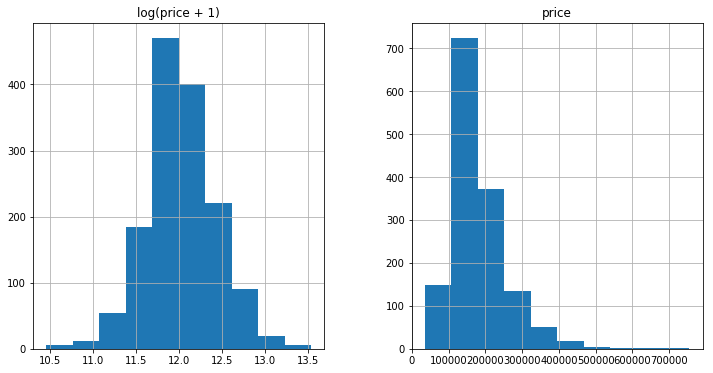

In [30]:
# Нормализация Price
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [31]:
#Нормализация для цели:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Нормализация для искаженных числовых фичей:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #вычисление искажения
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [33]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

C:\Users\bashk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [35]:
# One-hot encoding для номинативных переменных
all_data = pd.get_dummies(all_data)

In [37]:
# Замена NA на средние значения по столбцу
all_data = all_data.fillna(all_data.mean())

In [38]:
# Создание матриц для sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Model

Теперь мы будем использовать регуляризованные модели линейной регрессии из модуля обучения Scikit. Я собираюсь попробовать регуляризацию l_1 (Lasso) и l_2 (Ridge). Я также определю функцию, которая возвращает ошибку перекрестной проверки <b>rmse</b>, чтобы мы могли оценить наши модели и выбрать лучший параметр настройки

In [39]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge

In [40]:
model_ridge = Ridge()

Основным параметром настройки для модели Ridge является альфа <b>a</b> - параметр регуляризации, который измеряет гибкость нашей модели. Чем выше регуляризация, тем менее склонна наша модель к переобучению. Но также теряется гибкость и можно не захватить весь сигнал в данных.

In [41]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

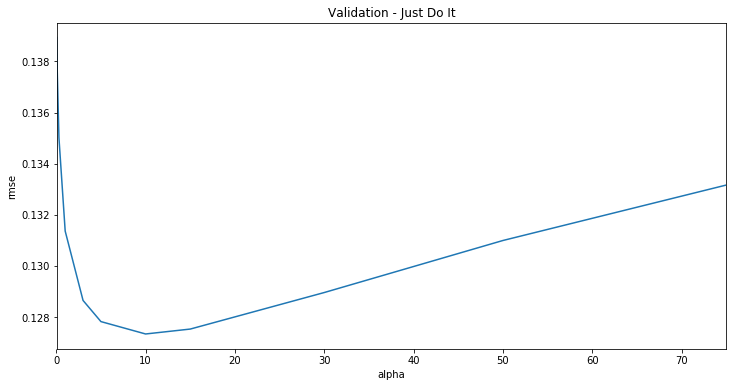

In [42]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Когда альфа слишком велика, регуляризация слишком сильна, и модель не может охватить все сложности в данных. Однако, если мы допустим, чтобы модель была слишком гибкой (альфа-маленькая), модель начинает переобучаться. Значение альфа = 10 - лучший вариант.

In [43]:
# Лучшая ошибка для Ridge
cv_ridge.min()

0.1273373466867077

### Lasso

Попробуем модель Lasso. Мы сделаем здесь немного другой подход и воспользуемся встроенным в Lasso CV, чтобы определить лучшую альфу для нас.

In [45]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5).fit(X_train, y)

In [46]:
rmse_cv(model_lasso).mean()

0.12256735885048127

Лассо работает лучше, поэтому мы будем использовать его для прогнозирования на тестовом наборе. Еще одна приятная вещь в Lasso заключается в том, что он делает выбор фичей - устанавливает коэффициенты фичей, которые он считает неважными, равными нулю. Давайте посмотрим на коэффициенты:

In [47]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Хорошая работа, Лассо! Однако следует отметить, что выбранные фичи не обязательно являются «правильными», тем более что в этом наборе данных много коллинеарных признаков. Одна из идей - попробовать запустить Lasso несколько раз на бутстрапированных выборках и посмотреть, насколько стабилен выбор признаков. Мы также можем взглянуть непосредственно на то, что наиболее важные коэффициенты:

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

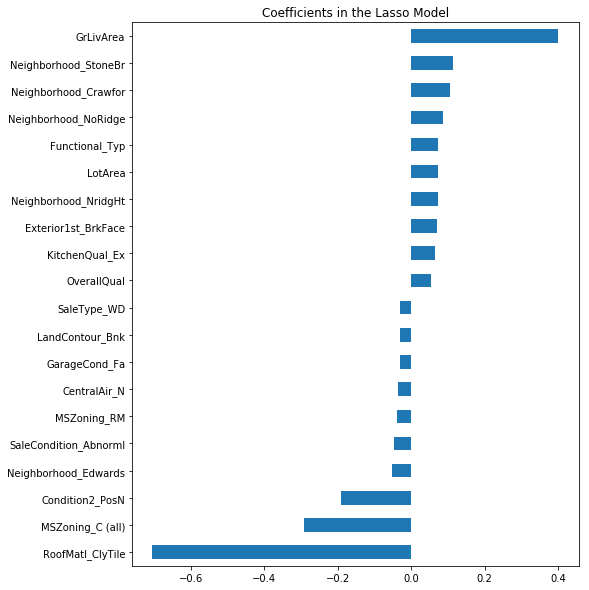

In [48]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Наиболее важной положительной чертой является GrLivArea - площадь земли в квадратных футах. Это имеет смысл. Некоторые из негативных особенностей имеют меньший смысл и стоило бы их рассмотреть лучше - кажется, что они могут быть вызваны несбалансированными категориальными переменными. Также обратите внимание, что в отличие от важности признака, которую вы получите из случайного леса, это фактические коэффициенты в вашей модели - так что вы можете точно сказать, почему прогнозируемая цена такая, какая она есть. Единственная проблема здесь заключается в том, что мы нормализовали как целевой, так и числовые признаки, поэтому фактические величины немного сложно интерпретировать.

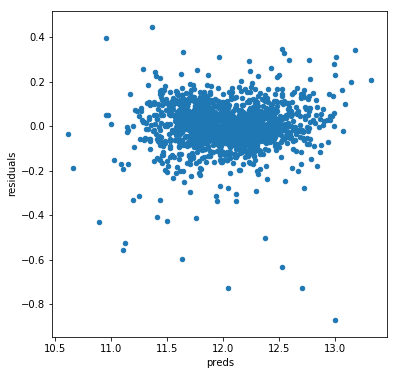

In [49]:
# Посмотрим на остатки
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Остаточный график выглядит довольно хорошо. Чтобы подвести итоги, можно делать прогноз.